In [122]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import yfinance as yf
import pandas as pd
import seaborn as sns

from datetime import datetime
from sklearn.linear_model import LinearRegression
from scipy.stats import norm, t
from tqdm import tqdm


%matplotlib inline

Plan financial engineering expo 1

Grp 1 : 

Product (7 slides) : 
- overall presentation ✅
- Benefit and risk 
- Best and worst scenario (variation sous jacent, coupons, taux de change), ✅

Market (5 slides): 
- historical trend du sous-jacent ✅
- du taux de change utilisé ✅

Modeling (19 slides) : 
- equations de modélisation (local volatility framework) ✅
- SABR Model for implied volatility ✅
- conversion from implied volatility to local volatility ✅
- GBM, instantaneous Covariance Structure ✅
- Model Risk and Simplifying assumptions (correlation risk is constant, distribution risk are normally distributed, fees and embedded costs are not explicitly included in price, …)
- validity test (test of normality) ✅
- implications of deviations from normality (fat tail, …) ✅
- Historical dependency between assets ✅
- justification of the constant correlation assumption

Calibration (15 slides) : 
- Yield curve construction (cubic spline interpolation)
- interpolated risk-free yield curves
- Computation of empirical covariance and correlation
- estimated volatility and correlation
- the way to calibrate local volatile surface
- implied volatility via BS Inversion (Brent’s method)
- SABR model calibration (quantLib.SABRInterpolation using the Levenberg-Marquardt algorithm)
- SABR Implied volatility surface (short and long maturity)
- from SABR surface to local volatility (Time derivative, strike derivatives)

Pricing methodology (8 slides) :
- forward rates calculation
- discretization of asset dynamics (model setup)
- Random number generation for simualtion for MC and QMC (and comparaison of the methods)
- fair value based on an initial investment of 1M JPY (gap correspond to insurance cost)
- convergence comparaison of MC and QMC (MC_SolSurf_P, Halton_sim, …)

Q-mesure (6 slides) : ? 

P-mesure : comparaison with Q-mesure (unimodal vs bimodal distribution = Historical data vs implied volatility)

Analysis : 
- Fair value comparaison (Q-mesure)
- Fat tails in Nikkei 225 returns (QQ-plot) ✅
- Volatility Smile (SABR implied volatility surface)
- why impact of fair value so small (/!\ pas sûr qu’on ait ça nous)
- Scenario Breakdown (where payoff land)

Conclusion : 
- Recap
- if we we buy this product
- futur work (Dimension reduction via Brownian Bridge)

Idées supplémentaires : 
- ML pour prédire le cours des actions et avoir un nouveau pricing
- ajout de suivi de la presse
- est ce que ce produit a réellement été acheté ? 

## Product :

- overall presentation
- Benefits and risks
- Best and worst scenario (variation du sous jacent, coupons, taux de change)

## Market : 

- conversion rate between yen and euros
- historical trend of the underlying asset


/var/folders/k6/tkt2xb056ksgrwnd0n53bzgw0000gn/T/ipykernel_78301/1827673933.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  eurjpy = yf.download("EURJPY=X")["Close"]
[*********************100%***********************]  1 of 1 completed


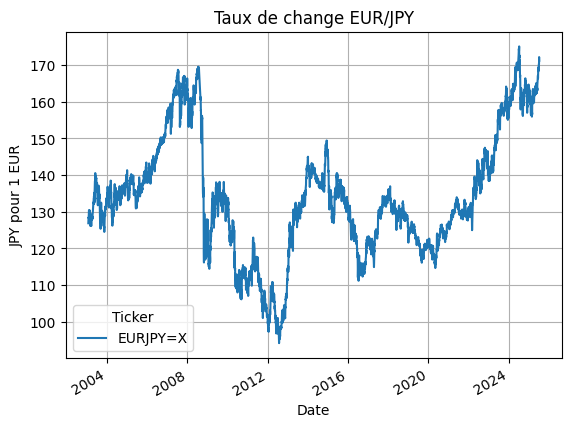

In [123]:
eurjpy = yf.download("EURJPY=X")["Close"]

# Tracer le taux de change
eurjpy.plot(title="Taux de change EUR/JPY")
plt.xlabel("Date")
plt.ylabel("JPY pour 1 EUR")
plt.grid(True)
plt.show()

In [124]:
tickers = ['TTE.PA', 'ASML', 'EN.PA', 'RI.PA']
data = yf.download(tickers, start="2022-01-01", end="2025-06-15")

/var/folders/k6/tkt2xb056ksgrwnd0n53bzgw0000gn/T/ipykernel_78301/3597107769.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2022-01-01", end="2025-06-15")
[*********************100%***********************]  4 of 4 completed


In [125]:
latest_prices = {'TTE.PA': np.float64(53.87),
                 'ASML.AS': np.float64(683.90),
                 'EN.PA': np.float64(38.51), 
                 'RI.PA': np.float64(94.74)}

latest_prices = np.array(list(latest_prices.values()))

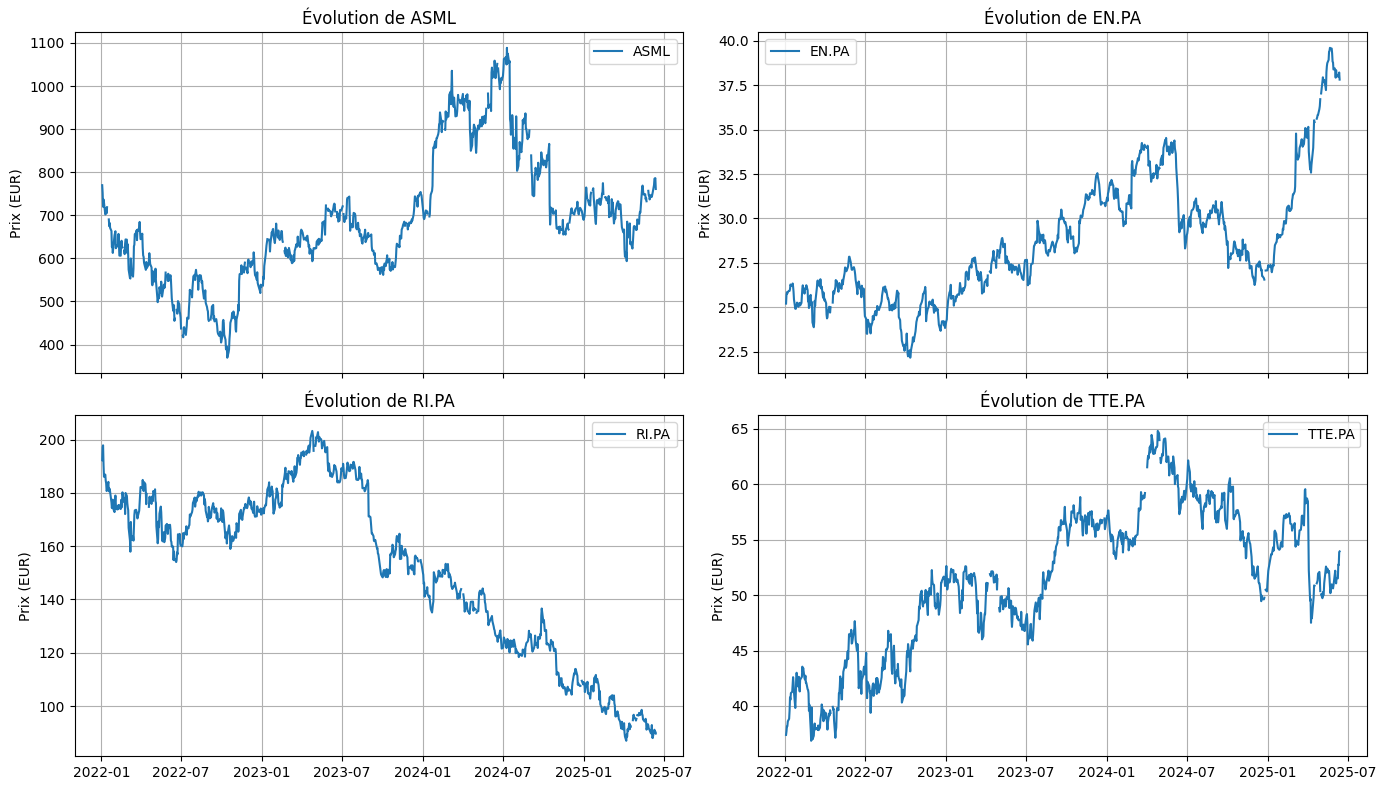

In [126]:
close_prices = data.xs('Close', axis=1, level='Price')

fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharex=True)
axes = axs.flatten()

for i, ticker in enumerate(close_prices.columns):
    axes[i].plot(close_prices.index, close_prices[ticker], label=ticker)
    axes[i].set_title(f"Évolution de {ticker}")
    axes[i].set_ylabel("Prix (EUR)")
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout()
plt.show()

In [127]:
def plot_heatmap(matrix, title, filename):
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix, xticklabels=assets, yticklabels=assets, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(title)
    plt.tight_layout()

## Model :

In [128]:
T = 10.0       # total time (10 years)
N = 2268       # number of steps (trading days)
dt = T / N
M = 1000        # number of MC simulations

d = 4  # number of assets 

dt = 1/252
N_steps = 2268

### Beginning : 

Simple model for the volatility (rate of increase). We'll see if we keep this part after. 

In [129]:
#Volatility
close_prices = data.xs('Close', axis=1, level='Price')
returns = close_prices.pct_change().dropna()
vol = returns.std() * np.sqrt(252)
print(vol)


Ticker
ASML      0.430269
EN.PA     0.191624
RI.PA     0.238736
TTE.PA    0.251338
dtype: float64


/var/folders/k6/tkt2xb056ksgrwnd0n53bzgw0000gn/T/ipykernel_78301/3850889329.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()


Here is the coreraltion of the asset. To better grasp the variations and implement a MC multi asset, I will define a stochastic process for the correlation matrix.

In [130]:
close_prices = data['Close']

log_returns = np.log(close_prices / close_prices.shift(1)).dropna()
correlation_matrix = log_returns.corr()

print(correlation_matrix)

Ticker      ASML     EN.PA     RI.PA    TTE.PA
Ticker                                        
ASML    1.000000  0.139506  0.191259  0.135881
EN.PA   0.139506  1.000000  0.258970  0.301889
RI.PA   0.191259  0.258970  1.000000  0.159558
TTE.PA  0.135881  0.301889  0.159558  1.000000


In [131]:
# 1. Log-rendements
log_returns = np.log(close_prices / close_prices.shift(1)).dropna()

# 2. Matrice de corrélation
correlation_matrix = log_returns.corr()

# 3. Volatilités empiriques (std des rendements)
volatilities = log_returns.std()  # shape: (d,)

# 4. Construction de la matrice de covariance
covariance_matrix = correlation_matrix.values * np.outer(volatilities, volatilities)

covariance_matrix


array([[7.73944232e-04, 4.76207380e-05, 8.12346119e-05, 5.94455929e-05],
       [4.76207380e-05, 1.50555095e-04, 4.85133108e-05, 5.82508379e-05],
       [8.12346119e-05, 4.85133108e-05, 2.33092641e-04, 3.83079337e-05],
       [5.94455929e-05, 5.82508379e-05, 3.83079337e-05, 2.47294346e-04]])

Model equation : 

${\displaystyle dS_{t}=(r_{t}-d_{t})S_{t}\,dt+\sigma(S_t,t) S_{t}\,dW_{t}}$

with :
- $r_t$ : risk free rate
- $d_t$ : the dividends payed
- $S_t$ : price of the underlying asset
- $\sigma(S_t,t)$ : volatility

### Modèle SABR

We cannot use the SABR model for a worst-of autocall because SABR is a univariate model designed for vanilla European options on a single underlying. However, a worst-of autocall is a multi-asset, path-dependent product requiring the joint simulation of multiple asset paths and the dynamic evaluation of their minimum, which SABR cannot model.

---

$\Rightarrow$ Monte Carlo simulation with drift  $\mu$ estimated from risk-free rates (e.g. €STR, SOFR, interpolated OIS, or TONA for yen), and volatility $\sigma$ estimated from implied volatility.

### Implied volatility : 

Here we compute the implied volatility.

In [132]:
target_expiry = '2025-01-17'
target_date = datetime.strptime(target_expiry, '%Y-%m-%d')

def historical_volatility(ticker_symbol, window_days=252):
    ticker = yf.Ticker(ticker_symbol)
    hist = ticker.history(period=f"{window_days}d")
    returns = np.log(hist['Close'] / hist['Close'].shift(1)).dropna()
    vol = returns.std() * np.sqrt(252)  # annualisée
    return vol

for symbol in tickers:
    try:
        ticker = yf.Ticker(symbol)
        spot = ticker.history(period="1d")['Close'].iloc[-1]

        expirations = ticker.options
        if not expirations:
            print(f"{symbol}: No option found. Calculating historical volatility ")
            vol_hist = historical_volatility(symbol)
            print(f"{symbol} - Spot: {spot:.2f} € - Historical Volatility (1 year) : {vol_hist:.2%}")
            print("-" * 40)
            continue

        # Trouver la date d'expiration la plus proche >= target_date
        valid_expiries = [datetime.strptime(d, '%Y-%m-%d') for d in expirations if datetime.strptime(d, '%Y-%m-%d') >= target_date]
        if not valid_expiries:
            # Pas d'expiration après target_date, on prend la plus lointaine disponible
            expiry_date = max([datetime.strptime(d, '%Y-%m-%d') for d in expirations])
        else:
            expiry_date = min(valid_expiries)

        expiry_str = expiry_date.strftime('%Y-%m-%d')
        opt_chain = ticker.option_chain(expiry_str)
        calls = opt_chain.calls

        # Trouver ATM
        atm_row = calls.iloc[(calls['strike'] - spot).abs().argmin()]
        sigma_atm = atm_row['implied Volatility']

        print(f"{symbol} - Spot: {spot:.2f} €")
        print(f"Expiration used here: {expiry_str}")
        print(f"Strike ATM: {atm_row['strike']:.2f} €")
        print(f"Implicit volatility ATM: {sigma_atm:.2%}")
        print("-" * 40)
        
    except Exception as e:
        print(f"Error with {symbol}: {e}")


TTE.PA: No option found. Calculating historical volatility 
TTE.PA - Spot: 53.96 € - Historical Volatility (1 year) : 21.85%
----------------------------------------
Error with ASML: 'implied Volatility'
EN.PA: No option found. Calculating historical volatility 
EN.PA - Spot: 38.56 € - Historical Volatility (1 year) : 18.44%
----------------------------------------
RI.PA: No option found. Calculating historical volatility 
RI.PA - Spot: 92.94 € - Historical Volatility (1 year) : 27.17%
----------------------------------------


We only have 1 element in the list, because it's not able to calculate the implicite vol for the others 

### Historical vol : 

I thought that maybe bc of the geopolitical situation, the implict vol would be dirrenet to what's explected, to I thought maybe we could create diffents scenari : like what the maket thinks (implied vol), and also what would happend in a different context like pre Covid.

In [133]:
volatility_records = []

In [134]:
def get_valid_cols_and_fill(data, tol=0.05):
    # Interpoler et remplir NaN dans tout le DataFrame
    data_interp = data.interpolate(method='linear').ffill().bfill()
    n_rows = data_interp.shape[0]
    valid_cols = []
    for col in data_interp.columns:
        n_missing = data[col].isnull().sum()  # nombre de NaN avant interpolation
        if n_missing / n_rows <= tol:
            valid_cols.append(col)
    return data_interp[valid_cols]

In [135]:
def compute_returns_and_stats(data):
    returns = np.log(data / data.shift(1)).dropna()
    vols = returns.std() * np.sqrt(252)
    corr = returns.corr()
    return vols, corr

In [136]:
periods = {
    "Last 3 years": ("2022-07-01", "2025-07-01"),
}

for period_name, (start, end) in periods.items():
    print(f"\n--- {period_name} ---")
    data = yf.download(tickers, start=start, end=end)
    data_filled = get_valid_cols_and_fill(data)
    if data_filled.empty:
        print("Not valid tickers on the considered duration")
        continue

    close_cols = data_filled.columns[data_filled.columns.get_level_values(0) == 'Close']
    data_close = data_filled[close_cols]

    vols, corr = compute_returns_and_stats(data_close)

    for col in close_cols:
        ticker = col[1]
        vol = vols[col]
        print(f"{col} - Annual Vol : {vol:.2%}")
        volatility_records.append({
            "ticker": ticker,
            "vol": vol
        })

    print("\nCorrelation Matrix :")
    print(corr)
    print("-" * 50)

/var/folders/k6/tkt2xb056ksgrwnd0n53bzgw0000gn/T/ipykernel_78301/2503662633.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end)
[*********************100%***********************]  4 of 4 completed


--- Last 3 years ---
('Close', 'ASML') - Annual Vol : 41.23%
('Close', 'EN.PA') - Annual Vol : 18.97%
('Close', 'RI.PA') - Annual Vol : 22.48%
('Close', 'TTE.PA') - Annual Vol : 23.44%

Correlation Matrix :
Price            Close                              
Ticker            ASML     EN.PA     RI.PA    TTE.PA
Price Ticker                                        
Close ASML    1.000000  0.099133  0.148544  0.095762
      EN.PA   0.099133  1.000000  0.208235  0.273017
      RI.PA   0.148544  0.208235  1.000000  0.121095
      TTE.PA  0.095762  0.273017  0.121095  1.000000
--------------------------------------------------


In [137]:
df_vols = pd.DataFrame(volatility_records)
df_vols

,ticker,vol
0,ASML,0.412328
1,EN.PA,0.189688
2,RI.PA,0.224804
3,TTE.PA,0.234406


### Vol local : 

No need to calculate it, we have a multiasset financial product so we can't use the Dupire thing, so no need for local vol = > we keep those above

### Drift : 

The currency is EUR€ so we use the overnight risk-free rate €STR, which is the risk-free rate for a deposite on the target 2 platform. The rate is : 1.922 

⚠️ : see if we need P or Q meusure !

In [138]:
mu = 0.01922

### Normality test : 

In [139]:
returns.columns

Index(['ASML', 'EN.PA', 'RI.PA', 'TTE.PA'], dtype='object', name='Ticker')

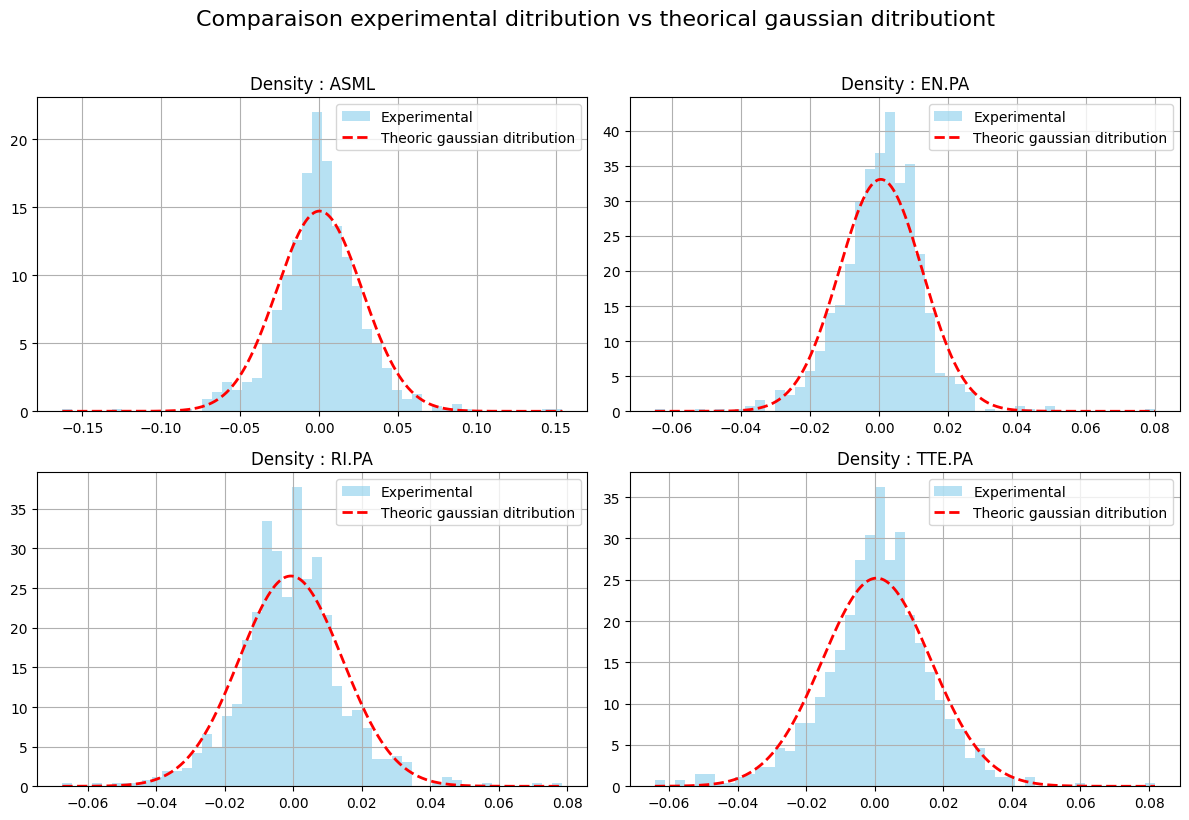

In [140]:
#Plot the gaussians for evry underlying asset
n = len(returns.columns)
n_cols = 2
n_rows = int(np.ceil(n / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(returns.columns):
    r = returns[col].dropna()
    mu, sigma = r.mean(), r.std()
    
    # Histogramme des rendements
    axes[i].hist(r, bins=50, density=True, alpha=0.6, color='skyblue', label="Experimental")

    # Courbe gaussienne théorique
    x = np.linspace(r.min(), r.max(), 500)
    axes[i].plot(x, norm.pdf(x, mu, sigma), 'r--', lw=2, label="Theoric gaussian ditribution")

    axes[i].set_title(f"Density : {col}")
    axes[i].legend()
    axes[i].grid(True)

# Supprimer les axes vides s'il y en a
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Comparaison experimental ditribution vs theorical gaussian ditributiont", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


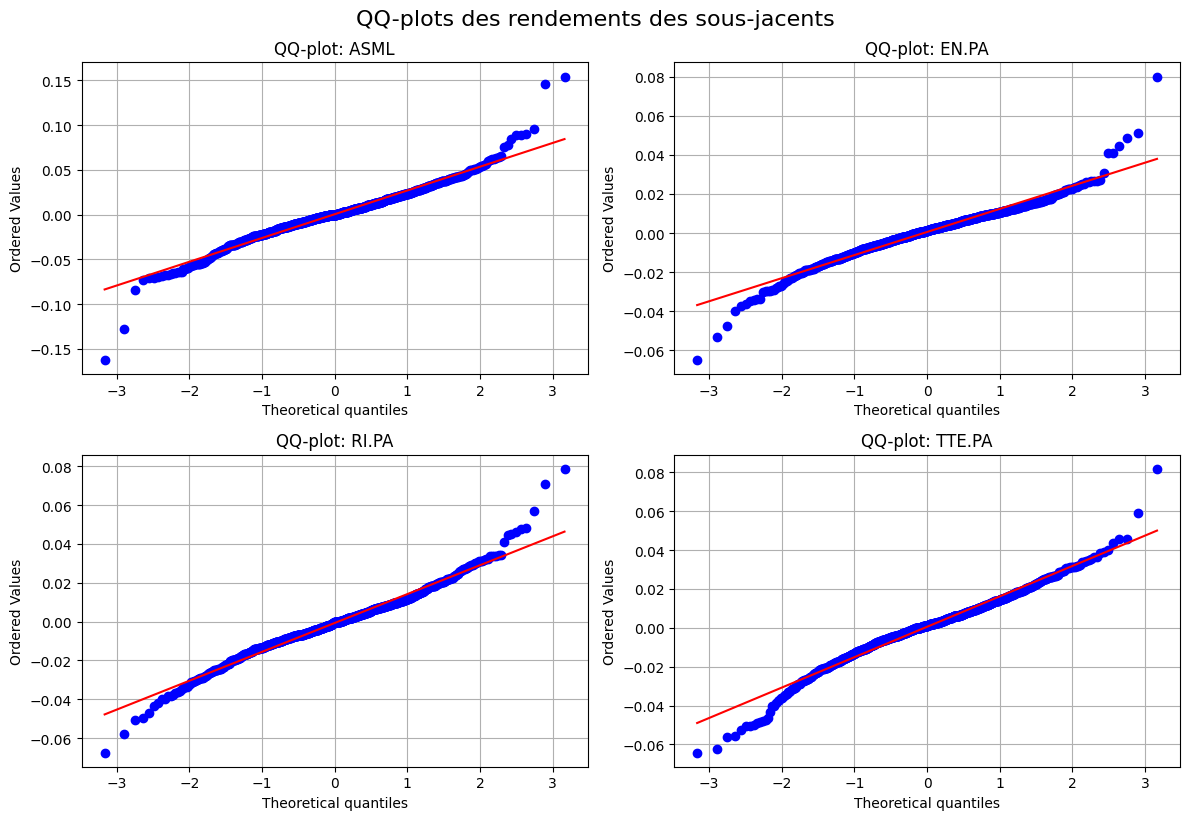

In [141]:
# Number of underlying assets
cols = returns.columns
n = len(cols)

# For the subplot
n_cols = 2
n_rows = int(np.ceil(n / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cols):
    stats.probplot(returns[col], dist="norm", plot=axes[i])
    axes[i].set_title(f"QQ-plot: {col}")
    axes[i].grid(True)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.suptitle("QQ-plots des rendements des sous-jacents", fontsize=16, y=1.02)
plt.show()


We can see that outiside $[-2,2]$, we have important deviation from gaussian ditribution, so we have to adapt to a fat tail model. We also have a lot of observated values in the middle, near 0.

In [142]:
for col in returns.columns:
    r = returns[col].dropna()
    k = stats.kurtosis(r, fisher=False)  # if > 3 → leptokurtique
    s = stats.skew(r)
    print(f"{col} → Kurtosis : {k:.2f} | Skewness : {s:.2f}")


ASML → Kurtosis : 7.15 | Skewness : 0.02
EN.PA → Kurtosis : 7.28 | Skewness : -0.09
RI.PA → Kurtosis : 5.44 | Skewness : 0.18
TTE.PA → Kurtosis : 5.09 | Skewness : -0.31


In [143]:
for tik in tickers:
    mean_returns = returns[tik].mean()
    print(f" Mean return for {tik} : {mean_returns}")

 Mean return for TTE.PA : 0.0005377776705000698
 Mean return for ASML : 0.00035456840839405456
 Mean return for EN.PA : 0.0005288109294061366
 Mean return for RI.PA : -0.0007433502960311897


Very close to 0, we can assume that the returns are centred -> we add floc=0 in stat.t (avoid misleading volaititly in the fat tail according to chatGPT)

In [144]:
# Dict to save parameters for the t-distribution
t_params = {}

for ticker in tickers:
    ret = returns[ticker].dropna().values
    
    if len(ret) == 0:
        print(f"No returns for {ticker}, skipping...")
        continue
    
    # Student-t calibration with loc forced to 0
    nu_hat, loc_hat, sigma_hat = stats.t.fit(ret, floc=0)
    
    print(f"{ticker} - Student-t calibration:")
    print(f"  degrees of freedom (nu) = {nu_hat:.2f}")
    print(f"  location shift (fixed to 0) = {loc_hat:.4f}")
    print(f"  daily volatility (scale) = {sigma_hat:.4f}")
    print(f"  annualized volatility = {sigma_hat * np.sqrt(252):.4f}")
    print("-" * 40)
    
    t_params[ticker] = {
        'nu': nu_hat,
        'loc': loc_hat,
        'scale_daily': sigma_hat,
        'scale_annual': sigma_hat * np.sqrt(252)
    }


TTE.PA - Student-t calibration:
  degrees of freedom (nu) = 4.81
  location shift (fixed to 0) = 0.0000
  daily volatility (scale) = 0.0123
  annualized volatility = 0.1954
----------------------------------------
ASML - Student-t calibration:
  degrees of freedom (nu) = 4.32
  location shift (fixed to 0) = 0.0000
  daily volatility (scale) = 0.0201
  annualized volatility = 0.3187
----------------------------------------
EN.PA - Student-t calibration:
  degrees of freedom (nu) = 5.22
  location shift (fixed to 0) = 0.0000
  daily volatility (scale) = 0.0094
  annualized volatility = 0.1492
----------------------------------------
RI.PA - Student-t calibration:
  degrees of freedom (nu) = 4.87
  location shift (fixed to 0) = 0.0000
  daily volatility (scale) = 0.0117
  annualized volatility = 0.1856
----------------------------------------


In [145]:
# Number of underlying assets
cols = returns.columns
n = len(cols)

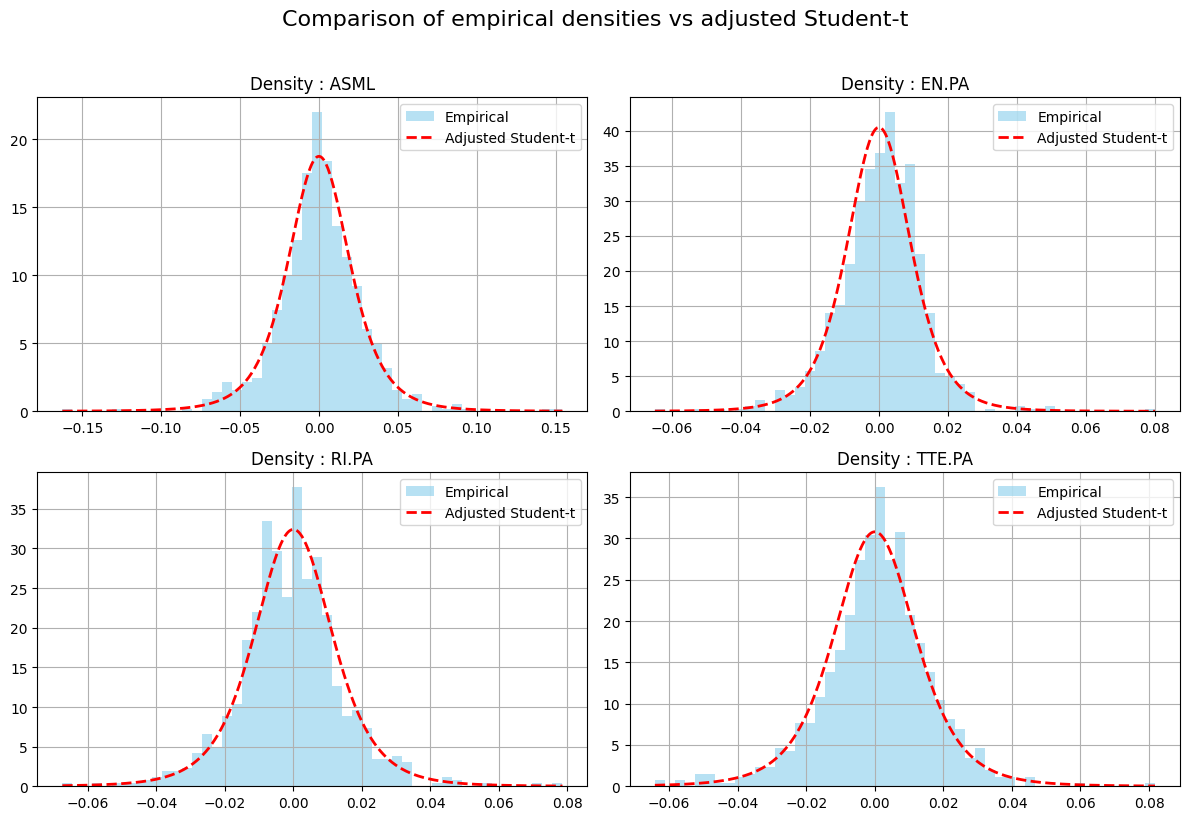

In [146]:
# Paramètres calibrés : degrés de liberté (nu) et scale (vol quotidien)
student_params = {
    "TTE.PA": {"nu": 4.81, "scale": 0.0123},
    "ASML": {"nu": 4.32, "scale": 0.0201},
    "EN.PA": {"nu": 5.22, "scale": 0.0094},
    "RI.PA": {"nu": 4.87, "scale": 0.0117}
}

# Affiche les courbes pour tous les actifs
n = len(returns.columns)
n_cols = 2
n_rows = int(np.ceil(n / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(returns.columns):
    r = returns[col].dropna()

    nu = student_params[col]["nu"]
    scale = student_params[col]["scale"]
    loc = 0  # centrée, comme supposé lors du calibrage

    # Histogramme des rendements
    axes[i].hist(r, bins=50, density=True, alpha=0.6, color='skyblue', label="Empirical")

    # Courbe de densité Student-t ajustée
    x = np.linspace(r.min(), r.max(), 500)
    pdf_student = t.pdf(x, df=nu, loc=loc, scale=scale)
    axes[i].plot(x, pdf_student, 'r--', lw=2, label="Adjusted Student-t")

    axes[i].set_title(f"Density : {col}")
    axes[i].legend()
    axes[i].grid(True)

# Supprimer les axes vides s'il y en a
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Comparison of empirical densities vs adjusted Student-t", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


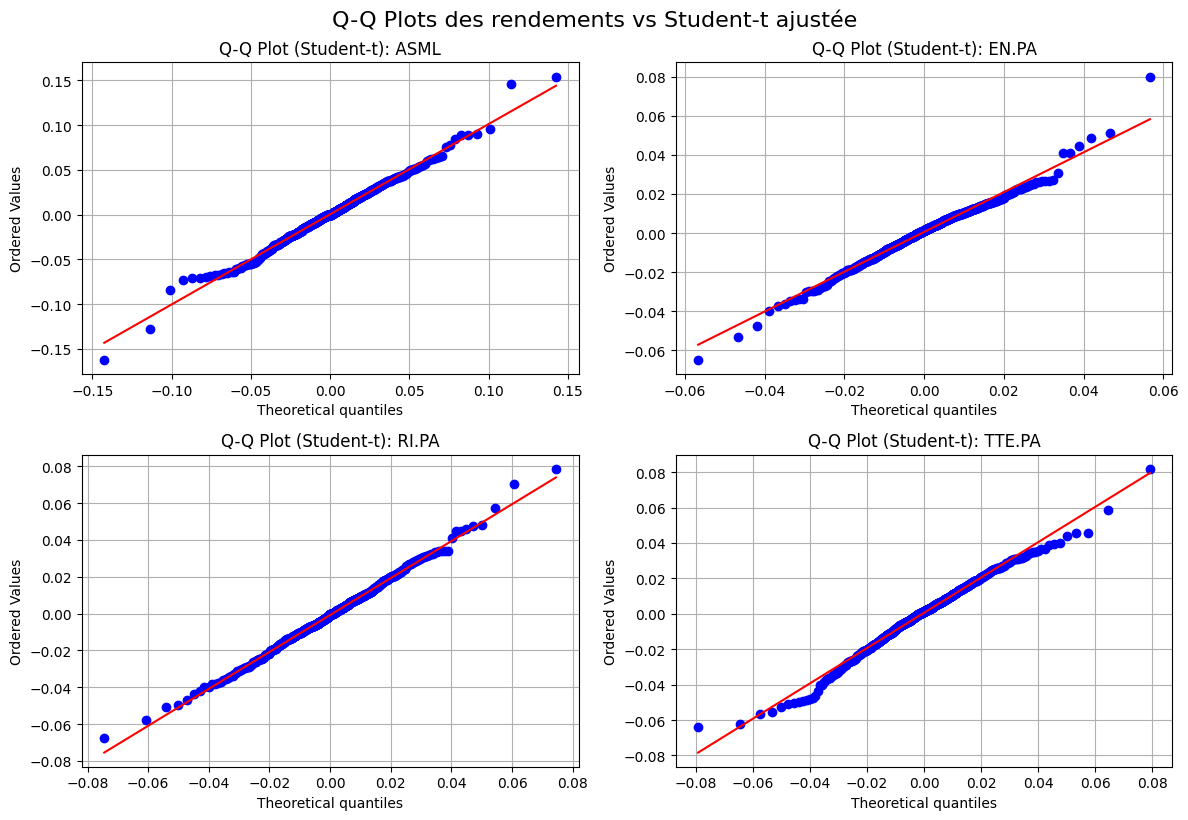

In [147]:
# Paramètres de la loi de Student calibrée (nu, loc, scale)
student_params = {
    "TTE.PA": {"nu": 4.81, "scale": 0.0123},
    "ASML": {"nu": 4.32, "scale": 0.0201},
    "EN.PA": {"nu": 5.22, "scale": 0.0094},
    "RI.PA": {"nu": 4.87, "scale": 0.0117}
}

# Liste des colonnes (sous-jacents)
cols = returns.columns
n = len(cols)

# Organisation des subplots
n_cols = 2
n_rows = int(np.ceil(n / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

# Génération des Q-Q plots
for i, col in enumerate(cols):
    r = returns[col].dropna()
    nu = student_params[col]["nu"]
    scale = student_params[col]["scale"]
    loc = 0  # centrage supposé

    stats.probplot(r, dist="t", sparams=(nu, loc, scale), plot=axes[i])
    axes[i].set_title(f"Q-Q Plot (Student-t): {col}")
    axes[i].grid(True)

# Suppression des axes vides s'il y en a
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.suptitle("Q-Q Plots des rendements vs Student-t ajustée", fontsize=16, y=1.02)
plt.show()


### Correlation evolution (Wishart process)

initial_corr is the correlation matrix defined in the intro, based on all of the historical data.
vol_cov_entries is the standard deviation of the correlation matrix across time → we calculate the correlation matrix for every span of 21 days on the historical data, then take the mean and calculate the standard deviation.

In [148]:
log_returns = np.log(close_prices / close_prices.shift(1)).dropna()
window = 21
cov_matrices = [log_returns.iloc[i-window:i].cov().values for i in range(window, len(log_returns))]
cov_matrices = np.array(cov_matrices)  # shape (num_windows, d, d)
mean_cov = np.mean(cov_matrices, axis=0)*252
vol_cov_entries = np.std(cov_matrices, axis=0)*np.sqrt(252)

In [149]:
def estimate_kappa(cov_matrices, dt):
    """
    Estimates kappa (mean reversion speed) for a Wishart process
    via an AR(1) regression on each element of the covariance matrix.

    Args:
        cov_matrices (np.ndarray): array of shape (T, d, d) containing historical covariance matrices
        dt (float): time step between each matrix (e.g., 1/252 for daily data)

    Returns:
        kappa_est (float): average estimate of kappa over all elements (i, j)
    """
    T, d, _ = cov_matrices.shape
    kappas = []

    # Perform the regression for each element of the matrix
    for i in range(d):
        for j in range(d):
            X_t = cov_matrices[:-1, i, j]    # covariance at time t
            X_tp1 = cov_matrices[1:, i, j]   # covariance at time t + dt
            delta_X = X_tp1 - X_t

            # Model: delta_X = kappa * (Theta - X_t) * dt
            # => delta_X / dt = kappa * (Theta - X_t)
            # Theta ~ empirical mean of X (stationarity assumption)
            Theta = np.mean(cov_matrices[:, i, j])

            y = delta_X / dt
            X = (Theta - X_t).reshape(-1, 1)

            # Linear regression y = kappa * X
            reg = LinearRegression(fit_intercept=False).fit(X, y)
            kappa_ij = reg.coef_[0]
            kappas.append(kappa_ij)

    kappa_est = np.mean(kappas)
    return kappa_est

In [150]:
kappa_est = estimate_kappa(cov_matrices, dt=1/252)
print("Estimation moyenne de kappa :", kappa_est)


Estimation moyenne de kappa : 8.389233385820486


In [151]:
def simulate_wishart_process(X0, Theta, kappa, G, dt, N_steps):
    """
    Simulates a discrete Wishart process.

    Args:
        X0 (np.ndarray): initial matrix (d x d symmetric positive definite)
        Theta (np.ndarray): long-term mean matrix (d x d)
        kappa (float): mean reversion speed
        G (np.ndarray): volatility matrix (d x d)
        dt (float): time step
        N_steps (int): number of iterations

    Returns:
        X_paths (np.ndarray): process trajectories of shape (N_steps+1, d, d)
    """


    d = X0.shape[0]
    X = X0.copy()
    X_paths = np.zeros((N_steps + 1, d, d))
    X_paths[0] = X0

    for t in range(1, N_steps + 1):
        # Matrix Brownian noise dW
        dW = np.random.normal(0, np.sqrt(dt), size=(d, d))
        
        # Diffusion terms
        sqrt_X = np.linalg.cholesky(X)  # Cholesky for positive definite square root
        diffusion = sqrt_X @ dW @ G + G.T @ dW.T @ sqrt_X

        # Deterministic drift term
        drift = kappa * (Theta - X) * dt
        
        # Discrete update
        X = X + drift + diffusion
        
        # Ensure X remains symmetric
        X = (X + X.T) / 2
        
        # Small correction if not positive definite (projection via eigenvalues)
        eigvals, eigvecs = np.linalg.eigh(X)
        eigvals_clipped = np.clip(eigvals, 1e-8, None)
        X = eigvecs @ np.diag(eigvals_clipped) @ eigvecs.T

        X_paths[t] = X

    return X_paths


In [152]:
print("X0 diag:", np.diag(mean_cov))
print("Theta diag:", np.diag(mean_cov))
print("G diag:", np.diag(vol_cov_entries))
print("dt =",dt)
print("N_step =", N_steps)
print("kappa =", kappa_est)

X0 = mean_cov
Theta = mean_cov
G = vol_cov_entries

X0 diag: [0.19835252 0.0382228  0.05876226 0.06319613]
Theta diag: [0.19835252 0.0382228  0.05876226 0.06319613]
G diag: [0.00815176 0.00133408 0.00216881 0.00280444]
dt = 0.003968253968253968
N_step = 2268
kappa = 8.389233385820486


kappa estimate: 8.3892


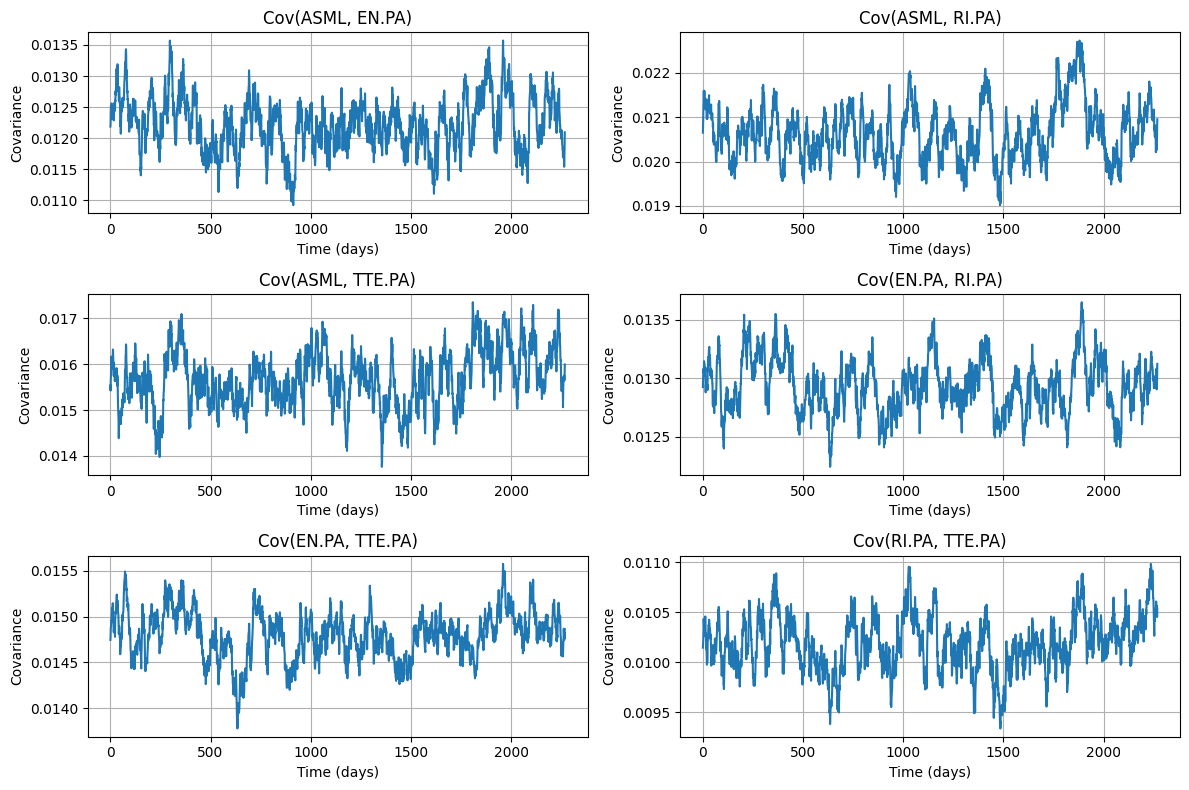

In [153]:
kappa = estimate_kappa(cov_matrices, dt)
print(f"kappa estimate: {kappa:.4f}")

X_paths = simulate_wishart_process(X0, Theta, kappa, G, dt, N_steps)
asset_names = correlation_matrix.columns.tolist()

d = len(asset_names)
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))
axs = axs.flatten()

plot_idx = 0
for i in range(d):
    for j in range(i + 1, d):
        axs[plot_idx].plot(X_paths[:, i, j])
        axs[plot_idx].set_title(f"Cov({asset_names[i]}, {asset_names[j]})")
        axs[plot_idx].set_xlabel("Time (days)")
        axs[plot_idx].set_ylabel("Covariance")
        axs[plot_idx].grid(True)
        plot_idx += 1

plt.tight_layout()
plt.show()



In [154]:
mu = 0.019

# MC : 

In [155]:
# Only keep 'close' columns
close_data = data['Close']

# take the last price 
spot_prices = close_data.iloc[-1]

print(spot_prices)
spot_prices.keys()

Ticker
ASML      801.390015
EN.PA      38.400002
RI.PA      84.599998
TTE.PA     52.099998
Name: 2025-06-30 00:00:00, dtype: float64


Index(['ASML', 'EN.PA', 'RI.PA', 'TTE.PA'], dtype='object', name='Ticker')

In [156]:
recent_vol = df_vols[["ticker", "vol"]].set_index('ticker')

In [157]:
def get_vol_from_df(df, ticker):
    try:
        return df.loc[ticker, 'vol']
    except KeyError:
        print(f"Volatility not found for {ticker} in the DataFrame.")
        return None

for ticker in spot_prices.keys():
    sigma_recent = get_vol_from_df(recent_vol, ticker)
    
    if sigma_recent is None:
        print(f"Skip {ticker} because the vol was missing")
        continue

In [158]:
def monte_carlo_paths(S0, mu, sigma, T, N, M):
    dt = T / N
    paths = np.zeros((M, N + 1))
    paths[:, 0] = S0
    for t in range(1, N + 1):
        Z = np.random.standard_normal(M)
        paths[:, t] = paths[:, t-1] * np.exp((mu - 0.5 * sigma**2)*dt + sigma * np.sqrt(dt) * Z)
    return paths

In [159]:
def monte_carlo_paths_tstudent_multivariate(S0, mu, sigma, T, N, M, nu):
    """
    Simule des trajectoires multivariées d'actifs avec innovations t-Student par actif.

    Args:
        S0 (array-like): Prix initiaux des actifs, shape (d,)
        mu (array-like): Drift annualisé des actifs, shape (d,)
        sigma (array-like): Volatilités annualisées des actifs, shape (d,)
        T (float): Horizon de temps total en années
        N (int): Nombre de pas de temps
        M (int): Nombre de simulations Monte Carlo
        nu (array-like): degrés de liberté de la loi t-Student par actif, shape (d,)

    Returns:
        np.ndarray: Trajectoires de prix, shape (M, N+1, d)
    """
    S0 = np.array(S0)
    mu = np.array(mu)
    sigma = np.array(sigma)
    nu = np.array(nu)

    d = len(S0)
    assert mu.shape == sigma.shape == nu.shape == (d,), "mu, sigma et nu doivent avoir shape (d,)"
    
    dt = T / N
    paths = np.zeros((M, N + 1, d))
    paths[:, 0, :] = S0  # prix initiaux

    for j in range(d):
        Z = np.random.standard_t(df=nu[j], size=(M, N))  # t-Student avec df spécifique à l'actif j
        scale = np.sqrt((nu[j] - 2) / nu[j])  # facteur correcteur
        returns = mu[j] * dt + sigma[j] * scale * np.sqrt(dt) * Z
        log_paths = np.cumsum(returns, axis=1)
        paths[:, 1:, j] = S0[j] * np.exp(log_paths)

    return paths


<Figure size 1200x500 with 0 Axes>

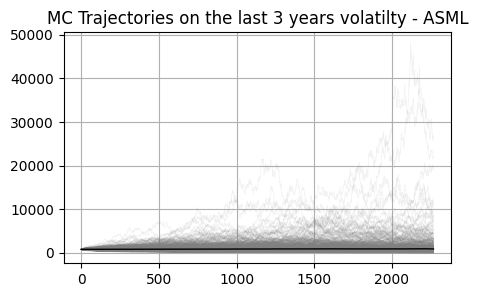

<Figure size 1200x500 with 0 Axes>

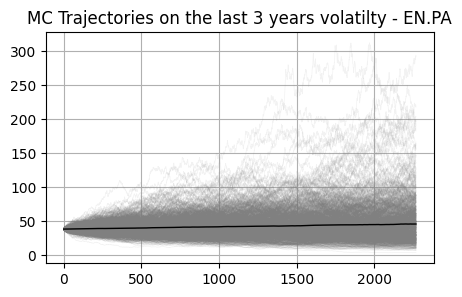

<Figure size 1200x500 with 0 Axes>

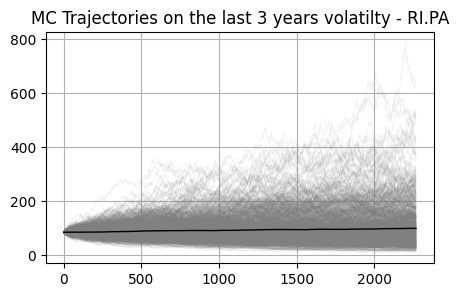

<Figure size 1200x500 with 0 Axes>

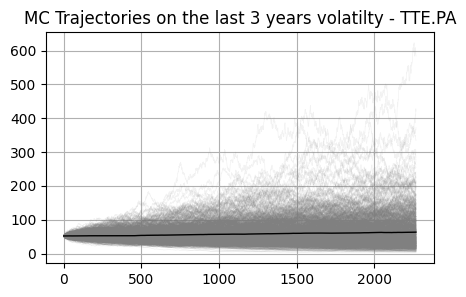

In [160]:
# simualtion and plot for each period of time
for ticker in spot_prices.keys():
    plt.figure(figsize=(12,5))

    # Trajectories based on last year volatility
    paths_recent = monte_carlo_paths(spot_prices.loc[ticker], mu, recent_vol.loc[ticker, 'vol'], T, N, M)

    plt.figure(figsize=(5, 3))
    for i in range(M):
        plt.plot(paths_recent[i], lw=0.5, alpha=0.1, color='gray')
    mean_path = paths_recent.mean(axis=0)
    plt.plot(mean_path, color='black', lw=1, label='Mean trajectory')
    plt.title(f"MC Trajectories on the last 3 years volatilty - {ticker}")
    plt.grid(True)
    plt.show()


In [161]:
# Ajustement sur les rendements
df, loc, scale = t.fit(returns)
nu = {}

for ticker in spot_prices.index:
    returns = log_returns[ticker].dropna().values
    df, _, _ = t.fit(returns)
    nu[ticker] = df

nu = pd.Series(nu)

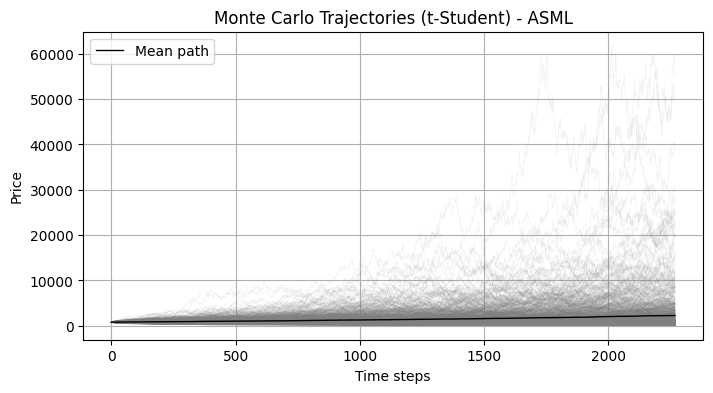

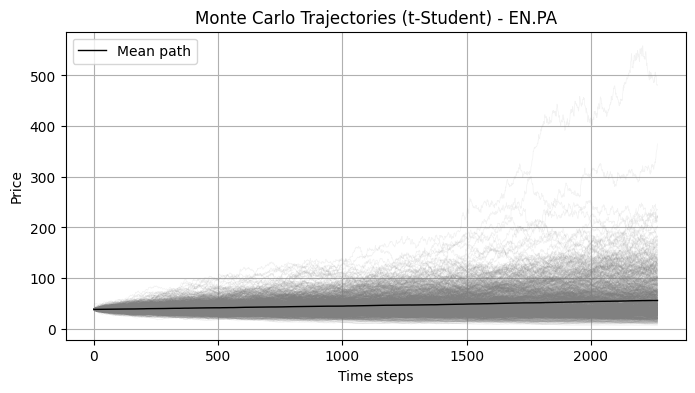

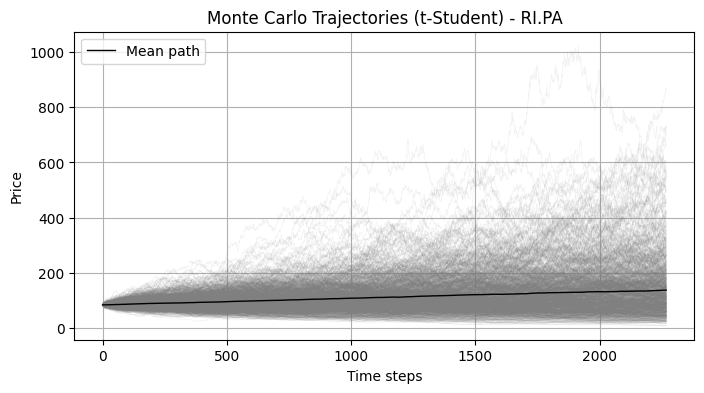

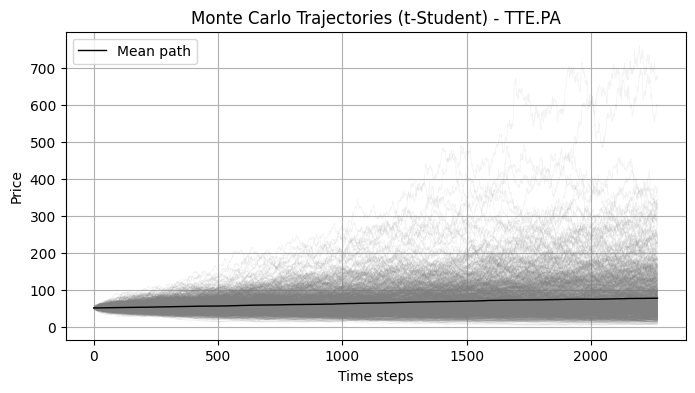

In [162]:
for i, ticker in enumerate(spot_prices.index):
    S0_ = [spot_prices[ticker]]            # shape (1,)
    mu_ = [mu]                              # constant drift
    sigma_ = [recent_vol.loc[ticker, 'vol']]
    nu_ = [nu.loc[ticker]]

    paths_recent = monte_carlo_paths_tstudent_multivariate(S0_, mu_, sigma_, T, N, M, nu_)
    
    plt.figure(figsize=(8, 4))
    for j in range(M):
        plt.plot(paths_recent[j, :, 0], lw=0.5, alpha=0.1, color='gray')
    plt.plot(paths_recent[:, :, 0].mean(axis=0), lw=1, color='black', label='Mean path')
    plt.title(f"Monte Carlo Trajectories (t-Student) - {ticker}")
    plt.xlabel("Time steps")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()
    plt.show()


I plotted the MC simulations for each asset, but now I want to make a MC for the mulkti asset, with a correlation matrix. I will establish the correlation matrix, and to be more realitic, I will make it stochastic (with a Wishart process).

In [ ]:
def monte_carlo_correlated_multivariate_tstudent(S0, mu, sigma, T, N, M, nu_vec, corr_matrix):
    """
    Simule des trajectoires d'actifs corrélés via Student-t multivarié.

    - S0 : vecteur des prix initiaux (shape: d,)
    - mu : drift vectoriel (shape: d,)
    - sigma : volatilités (shape: d,)
    - nu_vec : degrés de liberté Student-t (shape: d,)
    - corr_matrix : matrice de corrélation empirique (d x d)
    """
    dt = T / N
    d = len(S0)

    # Décomposition de Cholesky de la matrice de corrélation
    L = np.linalg.cholesky(corr_matrix)

    # Initialisation du tableau des trajectoires
    paths = np.zeros((M, N + 1, d))
    paths[:, 0, :] = S0

    # Simulation pas par pas
    for t_step in range(1, N + 1):
        # Générer des chocs Student-t indépendants pour chaque actif
        Z_indep = np.array([
            t.rvs(df=nu_vec[i], size=M) * np.sqrt((nu_vec[i] - 2) / nu_vec[i])
            for i in range(d)
        ]).T  # shape: (M, d)

        # Introduire la corrélation
        Z_corr = Z_indep @ L.T  # shape: (M, d)

        # Calculer les multiplicateurs exponentiels pour chaque actif
        drift = (mu - 0.5 * sigma**2) * dt
        diffusion = sigma * np.sqrt(dt) * Z_corr

        # Mise à jour des log-prix
        log_returns = drift + diffusion
        paths[:, t_step, :] = paths[:, t_step - 1, :] * np.exp(log_returns)

    return paths


In [164]:
df_vols.vol

0    0.412328
1    0.189688
2    0.224804
3    0.234406
Name: vol, dtype: float64

In [165]:
recent_vol.values

array([[0.41232806],
       [0.18968762],
       [0.22480449],
       [0.23440619]])

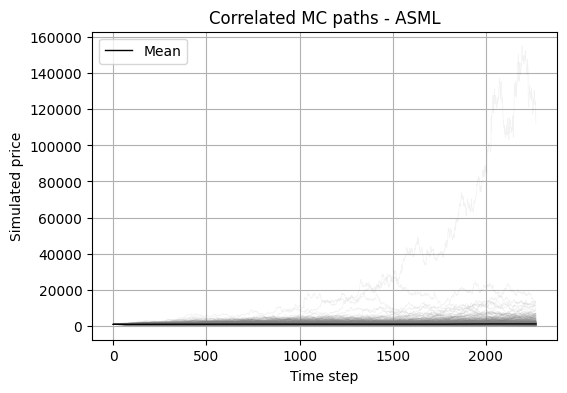

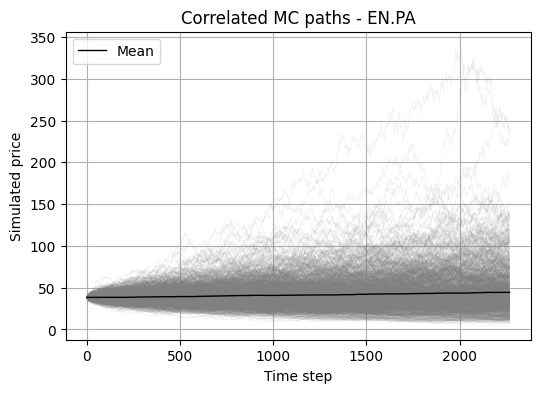

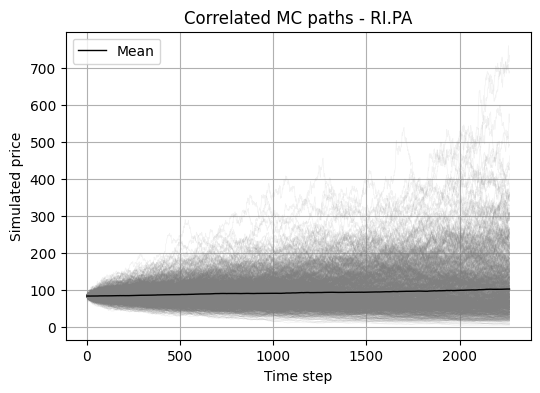

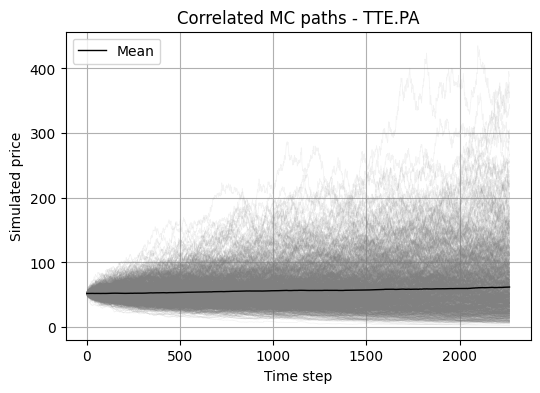

In [166]:
S0 = spot_prices.values             # shape (d,)
mu_vec = np.full_like(S0, mu)       # même drift pour tous (ou vectorisé)
sigma_vec = recent_vol.values.flatten()
nu_vec = nu[spot_prices.index].values
corr_matrix = correlation_matrix.values

paths = monte_carlo_correlated_multivariate_tstudent(
    S0, mu_vec, sigma_vec, T, N, M, nu_vec, corr_matrix
)

tickers = spot_prices.index.tolist()  # ['ASML', 'EN.PA', 'RI.PA', 'TTE.PA']

for i, ticker in enumerate(tickers):
    plt.figure(figsize=(6, 4))
    plt.plot(paths[:, :, i].T, lw=0.5, alpha=0.1, color='gray')
    plt.plot(paths[:, :, i].mean(axis=0), color='black', lw=1, label='Mean')
    plt.title(f"Correlated MC paths - {ticker}")
    plt.xlabel("Time step")
    plt.ylabel("Simulated price")
    plt.grid(True)
    plt.legend()
    plt.show()




In [167]:
def simulate_multivariate_asset_paths(S0, X_paths, mu, nu, dt, N_steps):
    d = len(S0)
    paths = np.zeros((N_steps + 1, d))
    vols = np.zeros((N_steps + 1, d))  # volatilité annualisée instantanée
    paths[0] = S0
    
    sqrt_dt = np.sqrt(dt)  # calcul une seule fois pour annualisation
    
    for t in range(1, N_steps + 1):
        cov_t = X_paths[t]
        
        try:
            L = np.linalg.cholesky(cov_t)
        except np.linalg.LinAlgError:
            cov_t = (cov_t + cov_t.T) / 2
            eigvals, eigvecs = np.linalg.eigh(cov_t)
            eigvals_clipped = np.clip(eigvals, 1e-8, None)
            cov_t = eigvecs @ np.diag(eigvals_clipped) @ eigvecs.T
            L = np.linalg.cholesky(cov_t)

       # Z = np.random.normal(size=d)
        Z = np.random.standard_t(df=nu, size=d)
        dW = L @ Z * sqrt_dt

        sigma_diag = np.sqrt(np.diag(cov_t))  # volatilité sur dt (ex: journalière)
        vols[t] = sigma_diag / sqrt_dt       # annualisation : diviser par sqrt(dt)

        drift = mu * dt
        diffusion = dW

        paths[t] = paths[t - 1] * np.exp(drift + diffusion)

    return paths, vols


In [168]:
S0 = close_prices.iloc[-1].values  #initial prices of the underlying assets (shape: d,)
mu_multi = np.full(len(S0), mu) # adapt the mu as a vector 

In [169]:
M = 1000
all_paths = np.zeros((M, N_steps + 1, len(S0)))
volat = np.zeros((M, N_steps + 1, len(S0)))

for i in tqdm(range(M)):
    all_paths[i] , volat[i] = simulate_multivariate_asset_paths(S0, X_paths, mu, nu, dt, N_steps)

log_returns_total = np.log(all_paths[:, -1, :] / all_paths[:, 0, :])  # shape: (num_paths, num_assets)
vol_empirique_10ans = np.std(log_returns_total, axis=0)
print("Volatilité empirique 10 ans par actif :", vol_empirique_10ans)

T = 10  # durée totale en années
vol_annuelle_estimee = vol_empirique_10ans / np.sqrt(T)
print("Volatilité annualisée estimée :", vol_annuelle_estimee)

100%|██████████| 1000/1000 [00:36<00:00, 27.62it/s]

Volatilité empirique 10 ans par actif : [1.76839019 0.76603159 0.9259283  1.01040081]
Volatilité annualisée estimée : [0.55921408 0.24224046 0.29280424 0.31951679]


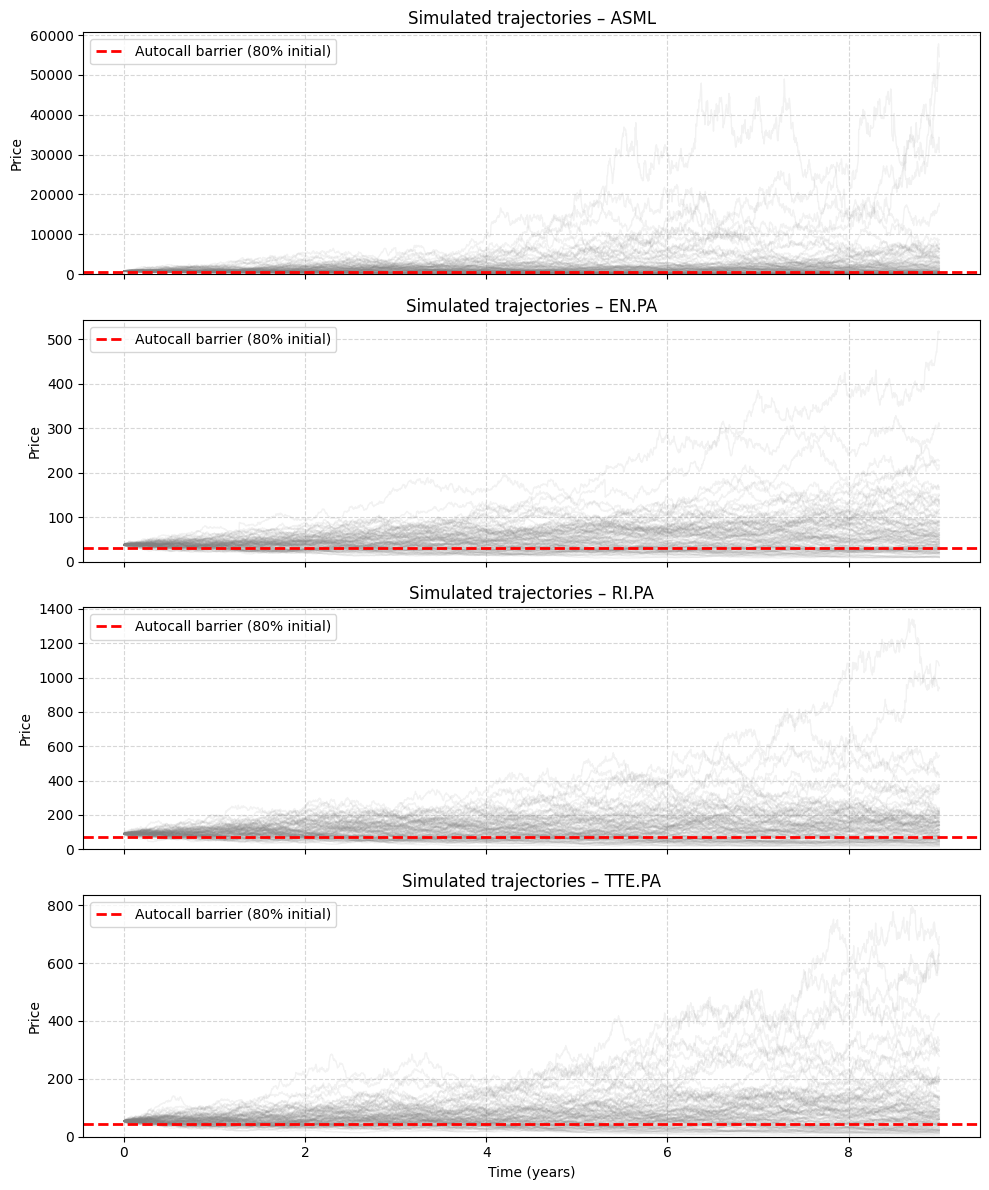

In [170]:
num_paths_to_plot = 100
num_assets = len(S0)

fig, axes = plt.subplots(num_assets, 1, figsize=(10, 3 * num_assets), sharex=True)

time = np.linspace(0, N_steps * dt, N_steps + 1)

for d_idx in range(num_assets):
    ax = axes[d_idx] if num_assets > 1 else axes
    for i in range(num_paths_to_plot):
        ax.plot(time, all_paths[i, :, d_idx], lw=1, alpha=0.1, color='gray')
    ax.set_title(f"Simulated trajectories – {asset_names[d_idx]}")
    ax.set_ylabel("Price")
    ax.grid(True, which='both', linestyle='--', alpha=0.5)
    
    barrier_level = 0.8 * S0[d_idx]
    ax.axhline(y=barrier_level, color='red', linestyle='--', linewidth=2, label=f'Autocall barrier (80% initial)')
    ax.legend()
    
    ax.set_ylim(bottom=0)  # Échelle verticale commence à 0

axes[-1].set_xlabel("Time (years)")
plt.tight_layout()
plt.show()


In [171]:
def monte_carlo_paths_tstudent_qmc(S0, mu, sigma, T, N, M, nu):
    """
    Simule des trajectoires multivariées d'actifs avec QMC et innovations t-Student.

    Args:
        S0 (array-like): Prix initiaux des actifs, shape (d,)
        mu (array-like): Drift annualisé des actifs, shape (d,)
        sigma (array-like): Volatilités annualisées des actifs, shape (d,)
        T (float): Horizon de temps total en années
        N (int): Nombre de pas de temps
        M (int): Nombre de simulations
        nu (array-like): Degrés de liberté par actif, shape (d,)

    Returns:
        np.ndarray: Trajectoires simulées, shape (M, N+1, d)
    """
    S0 = np.array(S0)
    mu = np.array(mu)
    sigma = np.array(sigma)
    nu = np.array(nu)

    d = len(S0)
    assert mu.shape == sigma.shape == nu.shape == (d,), "mu, sigma et nu doivent avoir shape (d,)"

    dt = T / N
    paths = np.zeros((M, N + 1, d))
    paths[:, 0, :] = S0  # prix initiaux

    for j in range(d):
        # === QMC uniformes [0, 1] ===
        sobol = qmc.Sobol(d=N, scramble=True)
        u = sobol.random(n=M)  # shape (M, N)

        # === Inverse transform sampling vers t-Student ===
        Z = t.ppf(u, df=nu[j])  # shape (M, N)
        
        # Correction d’échelle pour obtenir variance finie
        scale = np.sqrt((nu[j] - 2) / nu[j])
        returns = mu[j] * dt + sigma[j] * scale * np.sqrt(dt) * Z
        
        log_paths = np.cumsum(returns, axis=1)
        paths[:, 1:, j] = S0[j] * np.exp(log_paths)

    return paths


In [172]:
paths_recent_QMC= monte_carlo_paths_tstudent_multivariate(S0_, mu_, sigma_, T, N, M, nu_)

/var/folders/k6/tkt2xb056ksgrwnd0n53bzgw0000gn/T/ipykernel_78301/4238843879.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nu_ = [nu[i]]  # i entre 0 et 3 ici


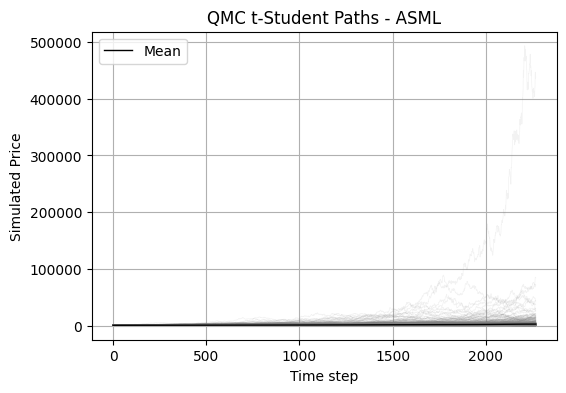

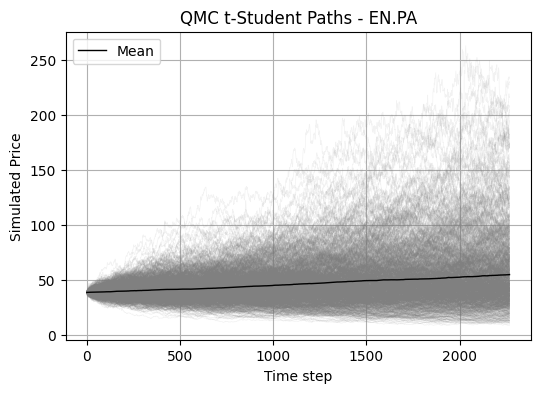

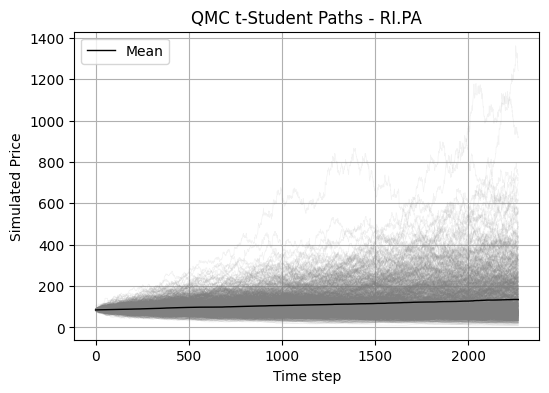

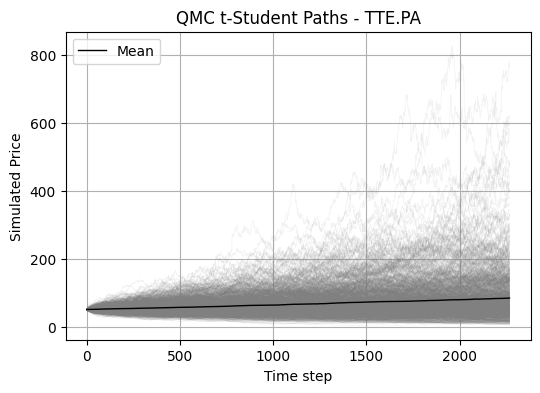

In [173]:
tickers = spot_prices.index.tolist()

for i, ticker in enumerate(tickers):
    S0_ = [spot_prices.loc[ticker]]
    mu_ = [mu]
    sigma_ = [recent_vol.loc[ticker, 'vol']]
    nu_ = [nu[i]]  # i entre 0 et 3 ici
    
    paths_recent_QMC = monte_carlo_paths_tstudent_multivariate(S0_, mu_, sigma_, T, N, M, nu_)

    plt.figure(figsize=(6, 4))
    for k in range(M):
        plt.plot(paths_recent_QMC[k, :, 0], lw=0.5, alpha=0.1, color='gray')
    plt.plot(paths_recent_QMC[:, :, 0].mean(axis=0), color='black', lw=1, label='Mean')
    plt.title(f"QMC t-Student Paths - {ticker}")
    plt.xlabel("Time step")
    plt.ylabel("Simulated Price")
    plt.grid(True)
    plt.legend()
    plt.show()


# Pricing

⚠️ We need to take into account that the Autocall barrier percentage is changing with respect to time. 

In [174]:
def calculate_cash_flows(normalized_paths, interest_barrier, autocall_barriers, knock_in_barrier, interest_rate, observation_dates):
    """
    Calculate cash flows for an autocallable product using normalized asset paths.

    Parameters:
    - normalized_paths: np.ndarray (num_paths, num_steps, num_assets), where all paths start at 1.0
    - interest_barrier: float, e.g. 0.9
    - autocall_barriers: list of float, e.g. [0.95, 0.95, ...]
    - knock_in_barrier: float, e.g. 0.6
    - interest_rate: float, e.g. 0.0255 for 2.55%
    - observation_dates: list of integers (indices in the time axis)

    Returns:
    - np.ndarray of shape (num_paths,) with the cash flow per path
    """
    num_paths = normalized_paths.shape[0]
    cash_flows = np.zeros(num_paths)
    end_time = np.zeros(num_paths) 

    autocall_flag = 0

    for path_idx in range(num_paths):
        path = normalized_paths[path_idx, :, :]
        path_cash_flow = 0

        for date_idx, obs_date in enumerate(observation_dates):
            prices = path[obs_date, :]
            worst_perf = np.min(prices)

            
            # 1. If worst performance is above the interest barrier, pay interest for all past quaters
            if worst_perf >= interest_barrier:
                path_cash_flow = interest_rate * 1000  * (date_idx +1)


            # 2. Check if autocall is triggered
            if worst_perf >= autocall_barriers[date_idx] and date_idx >= 3:
                path_cash_flow += 1000
                autocall_flag = 1
                
                break  # Autocall triggered → early exit

        # 3. If not autocalled, check if knock-in barrier is breached
        if autocall_flag == 0:
            final_prices = path[-1, :]
            worst_final = np.min(final_prices)

            if worst_final >= knock_in_barrier:
                path_cash_flow += 1000
            else:
                path_cash_flow += worst_final * 1000  # capital loss

        cash_flows[path_idx] = path_cash_flow
        end_time[path_idx] = (date_idx + 1) /4     #autcalled time in years

    return cash_flows, end_time

In [175]:
# Define the autocall barriers according to the document
autocall_barriers = [
    5, 5, 5, 5,             # First four quarters placeholder because there is no autocall  
    0.85, 0.85, 0.85, 0.85,  # next four quarters
    0.81, 0.81, 0.81, 0.81,  # Next four quarters
    0.77, 0.77, 0.77, 0.77,  # Following four quarters
    0.73, 0.73, 0.73, 0.73,  # And so on...
    0.69, 0.69, 0.69, 0.69,
    0.65, 0.65, 0.65, 0.65,
    0.61, 0.61, 0.61, 0.61,
    0.60, 0.60, 0.60, 0.60,
    0.60, 0.60, 0.60, 0.60
]

# Example usage
num_paths = 1000
num_steps = 252 * 10  # 10 years of daily data
num_underlyings = 4  # As per the document: TOTALENERGIES SE, ASML HOLDING NV, BOUYGUES SA, PERNOD RICARD SA
underlying_paths = all_paths
normalized_paths = underlying_paths / underlying_paths[:, 0, :][:, np.newaxis, :]
log_returns = np.log(normalized_paths[:, 1:, :] / normalized_paths[:, :-1, :])
vol_per_asset = np.std(log_returns, axis=(0, 1)) / np.sqrt(dt)  # annualisée

print("Simulated vol per year per asset :", vol_per_asset)



interest_barrier = 0.6
knock_in_barrier = 0.3
interest_rate = 0.0225  # 2.25%
observation_dates = np.linspace(0, normalized_paths.shape[1]-1, len(autocall_barriers) +1 , dtype=int)  # 40 observation dates
observation_dates = np.delete(observation_dates, 0)

cash_flows, end_times = calculate_cash_flows(normalized_paths, interest_barrier, autocall_barriers, knock_in_barrier, interest_rate, observation_dates)
print("Mean :", cash_flows.mean())

Simulated vol per year per asset : [0.5934316  0.25668902 0.31643384 0.32474326]
Mean : 986.4675


In [176]:
discounted_cash_flows = cash_flows * np.exp(-mu * end_times)
price = discounted_cash_flows.mean()
price_std = discounted_cash_flows.std()
standard_error = price_std / np.sqrt(M)

print("Whisart Pricing Summary for the Autocall Product")
print("="*50)
print(f"{'Mean Price':<25}: {price:,.2f} €")
print(f"{'Standard Deviation':<25}: {price_std:,.2f} €")
print(f"{'Standard Error':<25}: {standard_error:,.4f} €")
print(f"{'95% Confidence Interval':<25}: {price:,.2f} € ± {1.96 * standard_error:,.2f} €")

Whisart Pricing Summary for the Autocall Product
Mean Price               : 926.07 €
Standard Deviation       : 462.64 €
Standard Error           : 14.6300 €
95% Confidence Interval  : 926.07 € ± 28.67 €


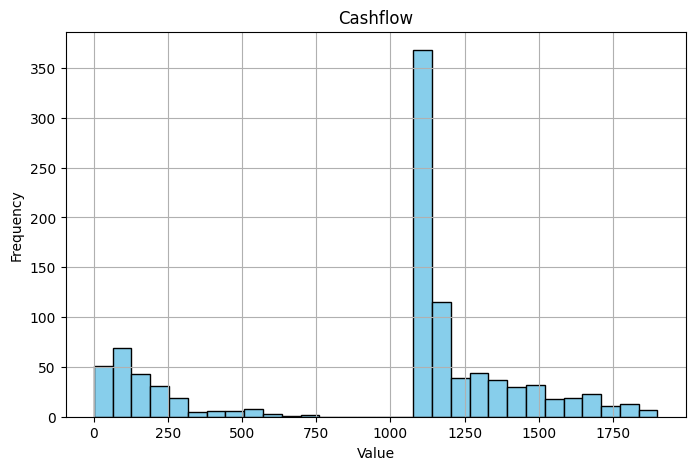

In [177]:
# plotting the histogram
plt.figure(figsize=(8, 5))
plt.hist(cash_flows, bins=30, color='skyblue', edgecolor='black')
plt.title("Cashflow")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [178]:
finals = normalized_paths[:, -1, :]
worst_finals = np.min(finals, axis=1)
print("Worst final mean:", np.mean(worst_finals))
print("Worst final < 0.6 (knock-in) ratio:", np.mean(worst_finals < 0.6))


Worst final mean: 0.6029965688098357
Worst final < 0.6 (knock-in) ratio: 0.64


In [179]:
final_prices = normalized_paths[:, -1, :]  # shape (num_paths, num_assets)

print("Moyennes finales par actif :", final_prices.mean(axis=0))
print("Écarts-types finaux par actif :", final_prices.std(axis=0))
print("Quantiles finaux par actif :", np.quantile(final_prices, [0.05, 0.5, 0.95], axis=0))

Moyennes finales par actif : [5.44902429 1.65405646 1.84269383 1.94257395]
Écarts-types finaux par actif : [19.21676367  1.48672956  2.1325794   2.1886244 ]
Quantiles finaux par actif : [[ 0.06589651  0.34479723  0.27105184  0.20228541]
 [ 1.11808634  1.24030224  1.25119226  1.22121734]
 [20.0986887   4.30689988  5.35220317  6.12302367]]


In [180]:
volatility_records

[{'ticker': 'ASML', 'vol': np.float64(0.41232805934368105)},
 {'ticker': 'EN.PA', 'vol': np.float64(0.18968762352237312)},
 {'ticker': 'RI.PA', 'vol': np.float64(0.22480448590279686)},
 {'ticker': 'TTE.PA', 'vol': np.float64(0.234406186106705)}]

In [181]:
last_year_vols = { 
    rec['ticker']: rec['vol'] 
    for rec in volatility_records 
}

print(last_year_vols)
tickers = ['ASML', 'EN.PA', 'RI.PA', 'TTE.PA']
sigma_vector = np.array([last_year_vols[ticker] for ticker in tickers])

{'ASML': np.float64(0.41232805934368105), 'EN.PA': np.float64(0.18968762352237312), 'RI.PA': np.float64(0.22480448590279686), 'TTE.PA': np.float64(0.234406186106705)}


In [182]:
all_paths_MC = monte_carlo_paths_tstudent_multivariate(S0, mu_multi, sigma_vector, T, N, M, nu)

Mean : 1038.3375


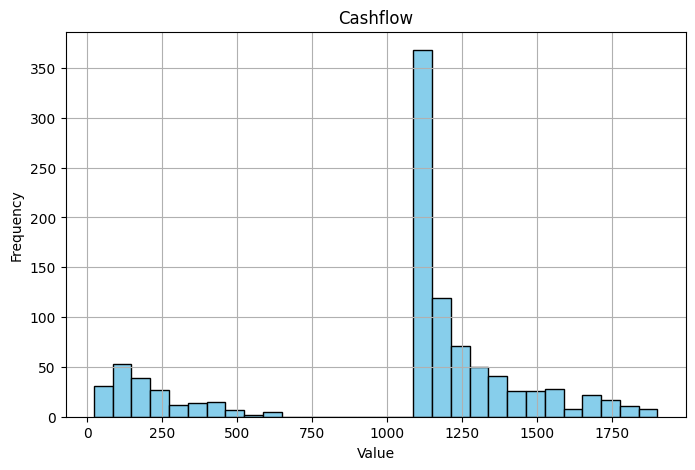

In [183]:
underlying_paths_MC = all_paths_MC
normalized_paths_MC = underlying_paths_MC / underlying_paths_MC[:, 0, :][:, np.newaxis, :]
log_returns_MC = np.log(normalized_paths_MC[:, 1:, :] / normalized_paths_MC[:, :-1, :])
vol_per_asset_MC = np.std(log_returns_MC, axis=(0, 1)) / np.sqrt(dt)  # annualisée

cash_flows_MC , end_times_MC = calculate_cash_flows(normalized_paths_MC, interest_barrier, autocall_barriers, knock_in_barrier, interest_rate, observation_dates)
print("Mean :", cash_flows_MC.mean())

# plotting the histogram
plt.figure(figsize=(8, 5))
plt.hist(cash_flows_MC, bins=30, color='skyblue', edgecolor='black')
plt.title("Cashflow")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [184]:
discounted_cash_flows_MC = cash_flows_MC * np.exp(-mu * end_times)
price_MC = discounted_cash_flows_MC.mean()
price_std_MC = discounted_cash_flows_MC.std()
standard_error_MC = price_std_MC / np.sqrt(M)

print("Monte Carlo Pricing Summary for the Autocall Product")
print("="*50)
print(f"{'Mean discounted cashflow':<25}: {price:,.2f} €")
print(f"{'Standard Deviation':<25}: {price_std:,.2f} €")
print(f"{'Standard Error':<25}: {standard_error:,.4f} €")
print(f"{'95% Confidence Interval':<25}: {price:,.2f} € ± {1.96 * standard_error:,.2f} €")

Monte Carlo Pricing Summary for the Autocall Product
Mean discounted cashflow : 926.07 €
Standard Deviation       : 462.64 €
Standard Error           : 14.6300 €
95% Confidence Interval  : 926.07 € ± 28.67 €


In [185]:
invested_amount = 1000
losses = invested_amount - discounted_cash_flows
losses_sorted = np.sort(losses)
var_level = 0.95  # pour une VaR à 95%
var_index = int((1 - var_level) * len(losses_sorted))
var_95 = losses_sorted[var_index]
print(f"VaR à {int(var_level*100)}% sur {invested_amount}€ investis selon Whisart: {var_95:.2f} €")


VaR à 95% sur 1000€ investis selon Whisart: -439.85 €


In [186]:
losses_MC = invested_amount - discounted_cash_flows_MC
losses_sorted_MC = np.sort(losses_MC)
var_index_MC = int((1 - var_level) * len(losses_sorted_MC))
var_95_MC = losses_sorted_MC[var_index_MC]
print(f"VaR à {int(var_level*100)}% sur {invested_amount}€ investis selon MC: {var_95_MC:.2f} €")

VaR à 95% sur 1000€ investis selon MC: -532.93 €
